<a href="https://colab.research.google.com/github/miskamvedebel/miskamvedebel/blob/master/Variational_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import theano
import theano.tensor as T

import pymc3 as pm

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from warnings import filterwarnings

floatX = theano.config.floatX
filterwarnings('ignore')
sns.set_style('white')

In [0]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)

In [0]:
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

[Text(0, 0.5, 'Y'),
 Text(0.5, 0, 'X'),
 Text(0.5, 1.0, 'Toy binary classification set')]

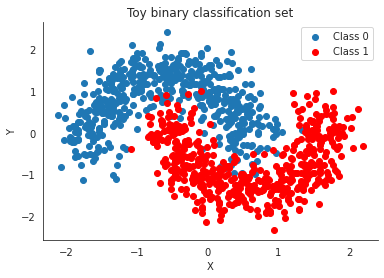

In [9]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], label='Class 0')
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color='r', label='Class 1')
sns.despine()
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification set')

In [0]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out, 
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

In [0]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [16]:
%%time
with neural_network:

  inference = pm.ADVI()
  approx = pm.fit(n=30000, method=inference)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 131.67: 100%|██████████| 30000/30000 [00:31<00:00, 965.25it/s]
Finished [100%]: Average Loss = 131.78


CPU times: user 29.2 s, sys: 3.31 s, total: 32.5 s
Wall time: 1min 16s


Text(0.5, 0, 'iteration')

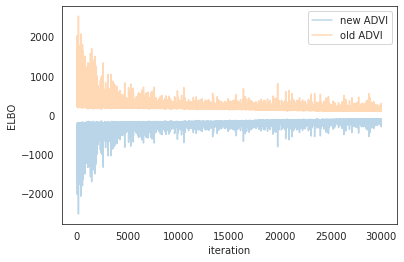

In [17]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [0]:
trace = approx.sample(draws=5000)

In [19]:
neural_network.out.distribution.p

sigmoid.0

In [0]:
x = T.matrix('X')
n = T.iscalar('n')

x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100

_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
sample_proba = theano.function([x, n], _sample_proba)

def production_step1():
    pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=True, model=neural_network)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [22]:
%timeit production_step1()

100%|██████████| 500/500 [00:04<00:00, 107.48it/s]


1 loop, best of 3: 4.66 s per loop


In [23]:
%timeit production_step2()

10 loops, best of 3: 103 ms per loop


In [0]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

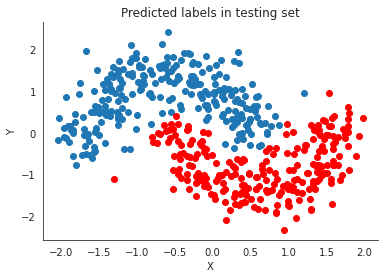

In [25]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [26]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.6%


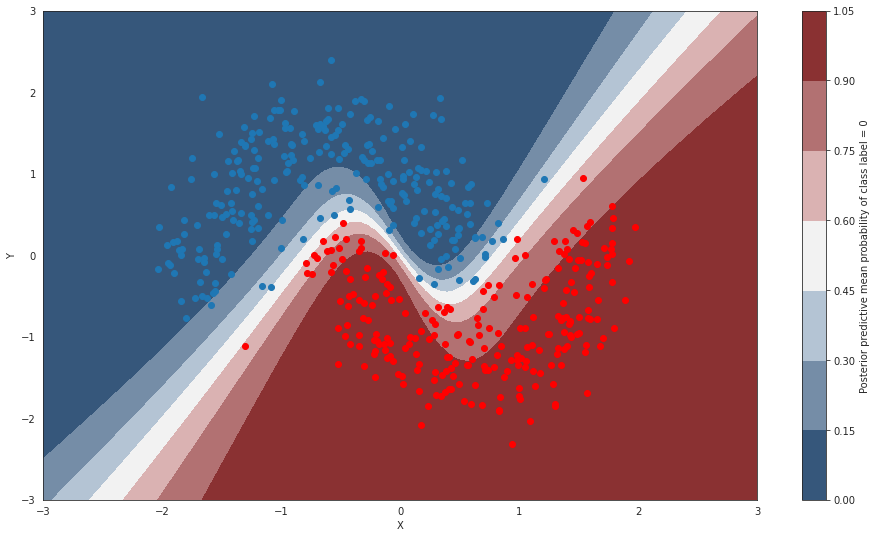

In [27]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)


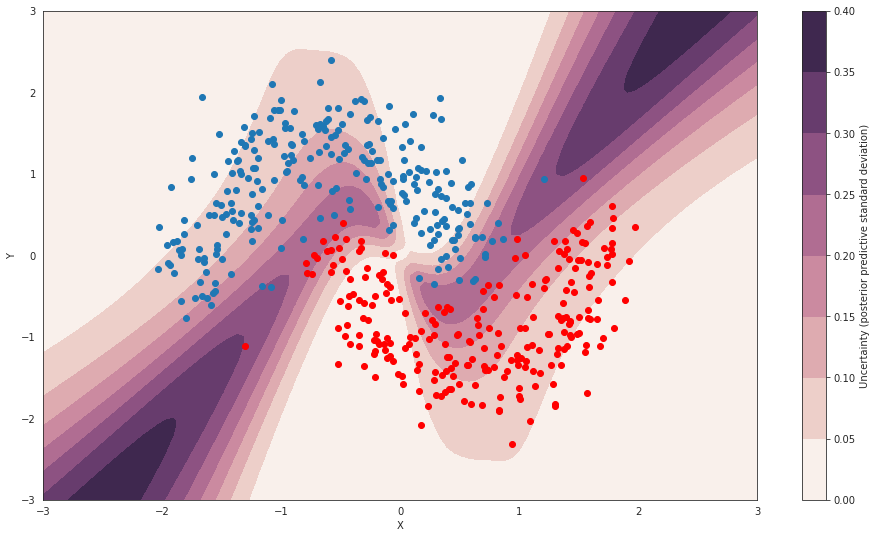

In [28]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [29]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 127.28: 100%|██████████| 40000/40000 [00:41<00:00, 969.55it/s]
Finished [100%]: Average Loss = 127.17


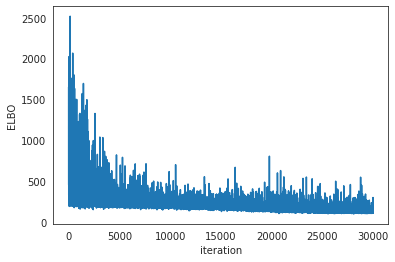

In [30]:
plt.plot(inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [32]:
!pip install arviz

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 44.9MB/s 
     |████████████████████████████████| 337kB 50.0MB/s 
